In [1]:
%pylab --no-import-all notebook
import sys 
sys.path.append("../modules")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import Classification as CL
import datasets as d

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import pandas as pd
from bunch import Bunch
import copy
import progressbar
from time import time

In [3]:
import os 
path = os.getcwd()
path = path.replace(path.split('/')[-1],'')
valid_path = path + "/Validační tabulky/"

In [4]:
data = d.load_dataset(name="first_dataset")

In [5]:
train, test = d.PrepareCrossFold(data.data)

In [6]:
def CrossVal(model, estimator_list, train_data, test_data, kombinace, params, 
             model_nm="RandomForest", dataset_nm="first", model_name_param=True):
    """
    Ještě není hotový
    """
    start = time()
    tab = np.empty([10]).tolist()
    
    for cross in range(10):
        bar = progressbar.ProgressBar(maxval=len(estimator_list),#+10,
                                      widgets=[progressbar.Bar('#', '[', ']'),
                                                   ' ', progressbar.Percentage()])
        
        train_matrix = CL.make_matrix(train_data[cross], kombinace, params)
        test_matrix = CL.make_matrix(test_data[cross], kombinace, params)
        
        
        labels = train_data[cross][0][2]
        for lab in train_data[cross][1:]:
            labels = np.hstack((labels, lab[2]))
        labels = labels.T
        
        [comb, estim, acc, miss, F0, F1, F2, F_avr, P0, P1, P2, R0, R1, R2, okno] = [[], [], [], [], [], [],
                                                                          [], [], [], [], [], [],
                                                                          [], [], []]
 
        bar.start()
        
        for i, est in enumerate(estimator_list):
            clf = copy.copy(model)
            clf.n_estimators = est
            #clf = RandomForestClassifier(n_estimators=est, criterion="entropy", max_depth=3)
            
            states = CL.train_and_predict(clf, 
                                          train_matrix, test_matrix, [], labels,
                                          unsupervised=False, HMMmodified=False)
            
            [a, m, f, f_a, p, r] = CL.score(states, test_data[cross][0][2], unsupervised=False)
            
            if kombinace == "all":
                kombinace = tuple(np.ones(5, dtype=int).tolist())
            
            comb.append(kombinace)
            estim.append(est)
            okno.append(params)
            acc.append(a)
            miss.append(m)
            F0.append(f[0])
            F1.append(f[1])
            F2.append(f[2])
            F_avr.append(f_a)
            P0.append(p[0])
            P1.append(p[1])
            P2.append(p[2])
            R0.append(r[0])
            R1.append(r[1])
            R2.append(r[2])
            bar.update(i)
            
           
        panda = list(zip(estim, comb, okno, acc, miss, F0, F1, F2, F_avr,
                     P0, P1, P2, R0, R1, R2))
        dpanda = pd.DataFrame(data=panda,
                          columns=['n_estim', 'Kombinace rysů', 'délky úseku', 'Accuracy', 'Chyby',
                                   'F míra stavu 0', 'F míra stavu 1', 'F míra stavu 2',
                                   'F míra průměrná', 'Precision stavu 0', 'Precision stavu 1',
                                   'Precision stavu 2', 'Recall stavu 0', 'Recall stavu 1',
                                   'Recall stavu 2'])
        tab[cross]=dpanda
        
        if model_name_param:
            model_name = f"{model_nm}_criterion={clf.criterion}_md={clf.max_depth}_{dataset_nm}_dataset_{cross}.csv"
        else:
            model_name = f"{model_nm}_dataset_{dataset_nm}_{cross}.csv"
        dpanda.to_csv(valid_path + model_name, index=False)
        
        bar.finish()
        print(cross + 1, '. -> ', round(time()-start))
        
        
    print(round(time()-start))
    return tab

In [7]:
"""
CLF = RandomForestClassifier(n_estimators=20, criterion="entropy", max_depth=3)

model_name = f"RandomForest_n-est={CLF.n_estimators}_crit=entropy_md=3_first_dataset_"

tab = np.empty([10]).tolist()

for i in range(10):
    tab[i] = CL.validace_hromadna(CLF, train[i], test[i], delka_okna=[[4, 6], [8, 10], [12, 14, 16], range(5,17)],\
                           pocet_stavu=3, unsupervised = False, HMMmodified=False)
    tab[i].to_csv(valid_path + model_name + str(i)+ '.csv',index=False)
    
"""

'\nCLF = RandomForestClassifier(n_estimators=20, criterion="entropy", max_depth=3)\n\nmodel_name = f"RandomForest_n-est={CLF.n_estimators}_crit=entropy_md=3_first_dataset_"\n\ntab = np.empty([10]).tolist()\n\nfor i in range(10):\n    tab[i] = CL.validace_hromadna(CLF, train[i], test[i], delka_okna=[[4, 6], [8, 10], [12, 14, 16], range(5,17)],                           pocet_stavu=3, unsupervised = False, HMMmodified=False)\n    tab[i].to_csv(valid_path + model_name + str(i)+ \'.csv\',index=False)\n    \n'

In [40]:
tabulky = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)])

[########################################################################] 100%


382


[########################################################################] 100%


786


[########################################################################] 100%


1194


[########################################################################] 100%


1611


[########################################################################] 100%


1987


[########################################################################] 100%


2389


[########################################################################] 100%


2789


[########################################################################] 100%


3189


[########################################################################] 100%


3592


[########################################################################] 100%


3996
3996


In [41]:
tabulky[9].sort_values(["F míra průměrná"], ascending=False).head()


,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
20,105,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.852336,531,0.885263,0.861728,0.800930,0.849307,0.881090,0.920844,0.790520,0.889476,0.809745,0.811617
13,70,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.850945,536,0.883574,0.865598,0.798137,0.849103,0.878265,0.923684,0.789555,0.888948,0.814385,0.806907
7,40,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.848165,546,0.879022,0.868389,0.797555,0.848322,0.883957,0.924084,0.776786,0.874141,0.819026,0.819466
34,175,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.850111,539,0.882275,0.862454,0.800153,0.848294,0.886752,0.925532,0.778190,0.877842,0.807425,0.823391
5,30,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.850667,537,0.883844,0.861042,0.799076,0.847987,0.882446,0.925333,0.783988,0.885246,0.805104,0.814757


<IPython.core.display.Javascript object>


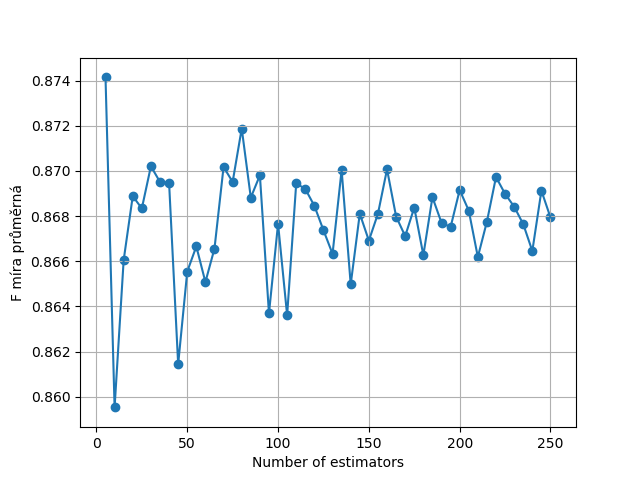

In [45]:
tab = tabulky[0]

plt.figure("F míra vs n_est")
plt.plot(tab["n_estim"], tab["F míra průměrná"])
plt.scatter(tab["n_estim"], tab["F míra průměrná"])
plt.xlabel("Number of estimators")
plt.ylabel("F míra průměrná")
plt.grid(True)
plt.show()

In [46]:
tabulky = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_1", 
                   dataset_nm="first")

[########################################################################] 100%


617


[########################################################################] 100%


1239


[########################################################################] 100%


1815


[########################################################################] 100%


2392


[########################################################################] 100%


2960


[########################################################################] 100%


3568


[########################################################################] 100%


4171


[########################################################################] 100%


4742


[########################################################################] 100%


5315


[########################################################################] 100%


5879
5879


<IPython.core.display.Javascript object>


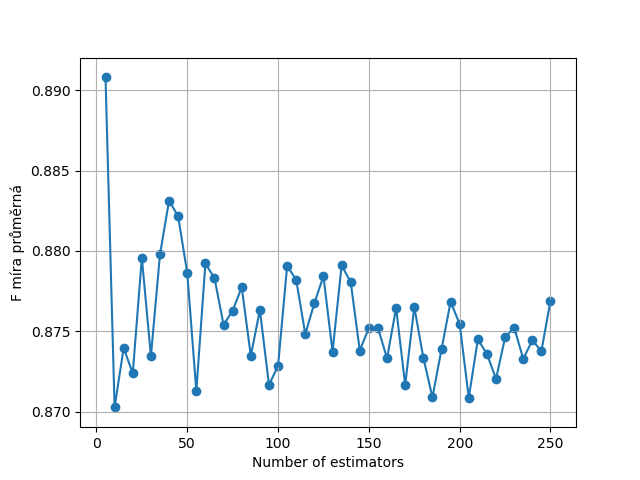

In [51]:
tab = tabulky[4]

plt.figure("F míra vs n_est 1")
plt.plot(tab["n_estim"], tab["F míra průměrná"])
plt.scatter(tab["n_estim"], tab["F míra průměrná"])
plt.xlabel("Number of estimators")
plt.ylabel("F míra průměrná")
plt.grid(True)
plt.show()

In [52]:
#chci udělat více měření. jelikož random forests jsou náhodné chci spíš průměry
tabulky_1 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_0", 
                   dataset_nm="first")

[########################################################################] 100%


703


[########################################################################] 100%


1332


[########################################################################] 100%


1973


[########################################################################] 100%


2600


[########################################################################] 100%


3215


[########################################################################] 100%


3822


[########################################################################] 100%


4446


[########################################################################] 100%


5054


[########################################################################] 100%


5685


[########################################################################] 100%


6253
6253


In [53]:
tabulky2 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_0", 
                   dataset_nm="first")

[########################################################################] 100%


379


[########################################################################] 100%


749


[########################################################################] 100%


1145


[########################################################################] 100%


1517


[########################################################################] 100%


1879


[########################################################################] 100%


2249


[########################################################################] 100%


2625


[########################################################################] 100%


3012


[########################################################################] 100%


3383


[########################################################################] 100%


3749
3749


In [55]:
tabulky3 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_1", 
                   dataset_nm="first")

[########################################################################] 100%


1 . ->  376


[########################################################################] 100%


2 . ->  1542786782


[########################################################################] 100%


3 . ->  794


[########################################################################] 100%


4 . ->  1542787167


[########################################################################] 100%


5 . ->  1168


[########################################################################] 100%


6 . ->  1542787542


[########################################################################] 100%


7 . ->  1536


[########################################################################] 100%


8 . ->  1542787920


[########################################################################] 100%


9 . ->  1930


[########################################################################] 100%


10 . ->  1542788307
3827


In [56]:
tabulky4 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_2", 
                   dataset_nm="first")

[########################################################################] 100%


1 . ->  403


[########################################################################] 100%


2 . ->  1542796384


[########################################################################] 100%


3 . ->  793


[########################################################################] 100%


4 . ->  1542796781


[########################################################################] 100%


5 . ->  1183


[########################################################################] 100%


6 . ->  1542797152


[########################################################################] 100%


7 . ->  1566


[########################################################################] 100%


8 . ->  1542797531


[########################################################################] 100%


9 . ->  1943


[########################################################################] 100%


10 . ->  1542797903
3847


In [58]:
tabulky5 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_3", 
                   dataset_nm="first")

[########################################################################] 100%


1 . ->  395.7020673751831


[########################################################################] 100%


2 . ->  782.2091841697693


[########################################################################] 100%


3 . ->  1191.846270084381


[########################################################################] 100%


4 . ->  2176.4748842716217


[########################################################################] 100%


5 . ->  2544.866302013397


[########################################################################] 100%


6 . ->  2953.4729931354523


[########################################################################] 100%


7 . ->  3333.6073491573334


[########################################################################] 100%


8 . ->  3708.8487763404846


[########################################################################] 100%


9 . ->  4107.092791080475


[########################################################################] 100%


10 . ->  4469.324944257736
4469


<IPython.core.display.Javascript object>


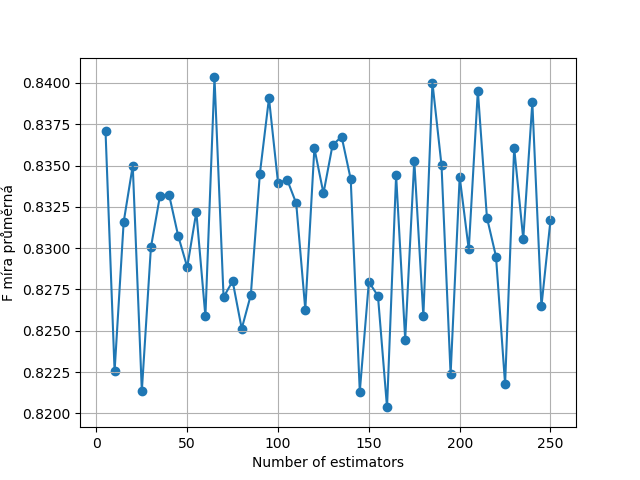

In [65]:
tab = tabulky_1[1]

plt.figure("F míra vs n_est 2")
plt.plot(tab["n_estim"], tab["F míra průměrná"])
plt.scatter(tab["n_estim"], tab["F míra průměrná"])
plt.xlabel("Number of estimators")
plt.ylabel("F míra průměrná")
plt.grid(True)
plt.show()

In [66]:
tabulky_2 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_2", 
                   dataset_nm="first")

[########################################################################] 100%


1 . ->  627.060173034668


[########################################################################] 100%


2 . ->  1211.3342537879944


[########################################################################] 100%


3 . ->  1790.5848679542542


[########################################################################] 100%


4 . ->  2364.1497280597687


[########################################################################] 100%


5 . ->  2938.821928024292


[########################################################################] 100%


6 . ->  3545.412568807602


[########################################################################] 100%


7 . ->  4117.821240901947


[########################################################################] 100%


8 . ->  4687.431745052338


[########################################################################] 100%


9 . ->  5270.308625936508


[########################################################################] 100%


10 . ->  5877.284962177277
5877


In [67]:
tabulky_2 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_3", 
                   dataset_nm="first")

[########################################################################] 100%


1 . ->  624.8490579128265


[########################################################################] 100%


2 . ->  1248.0449500083923


[########################################################################] 100%


3 . ->  1827.1563019752502


[########################################################################] 100%


4 . ->  2405.314421892166


[########################################################################] 100%


5 . ->  2970.6568460464478


[########################################################################] 100%


6 . ->  3541.171417951584


[########################################################################] 100%


7 . ->  4116.988847017288


[########################################################################] 100%


8 . ->  4765.942255020142


[########################################################################] 100%


9 . ->  5398.408117055893


[########################################################################] 100%


10 . ->  5988.713121891022
5989


In [68]:
tabulky_4 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_4", 
                   dataset_nm="first")

[########################################################################] 100%


1 . ->  586.1022217273712


[########################################################################] 100%


2 . ->  1191.4759917259216


[########################################################################] 100%


3 . ->  1792.481496810913


[########################################################################] 100%


4 . ->  2399.8227179050446


[########################################################################] 100%


5 . ->  3979.5129017829895


[########################################################################] 100%


6 . ->  4596.296113729477


[########################################################################] 100%


7 . ->  5303.20077085495


[########################################################################] 100%


8 . ->  6009.255971670151


[########################################################################] 100%


9 . ->  6727.808557033539


[########################################################################] 100%


10 . ->  7449.856408834457
7450


In [69]:
tabulky__0 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=2), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_0", 
                   dataset_nm="first")

[########################################################################] 100%


1 . ->  277.37109112739563


[########################################################################] 100%


2 . ->  578.240049123764


[########################################################################] 100%


3 . ->  4584.891349077225


[########################################################################] 100%


4 . ->  4845.126101970673


[########################################################################] 100%


5 . ->  5097.54594707489


[########################################################################] 100%


6 . ->  5360.178708076477


[########################################################################] 100%


7 . ->  5610.603482246399


[########################################################################] 100%


8 . ->  5878.607471227646


[########################################################################] 100%


9 . ->  6134.27961230278


[########################################################################] 100%


10 . ->  6395.564925193787
6396


<IPython.core.display.Javascript object>


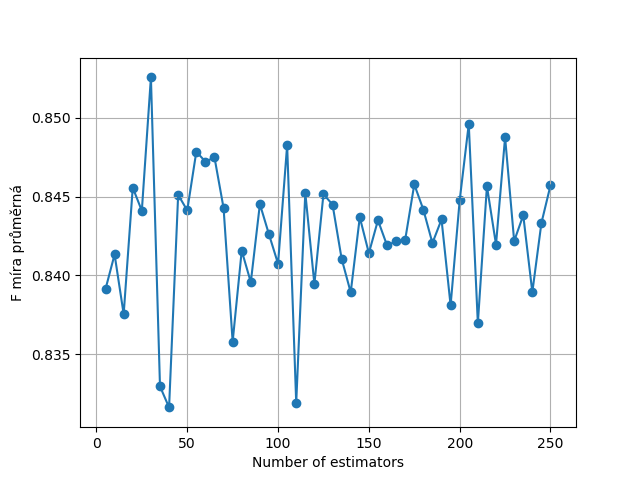

In [70]:
tab = tabulky__0[0]

plt.figure("F míra vs n_est md=2")
plt.plot(tab["n_estim"], tab["F míra průměrná"])
plt.scatter(tab["n_estim"], tab["F míra průměrná"])
plt.xlabel("Number of estimators")
plt.ylabel("F míra průměrná")
plt.grid(True)
plt.show()

# Ada boosting

In [79]:
tabulky_ada = CrossVal(model =AdaBoostClassifier(), 
                   estimator_list=[400], 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_0", 
                   dataset_nm="first",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  50


[########################################################################] 100%


2 . ->  100


[########################################################################] 100%


3 . ->  151


[########################################################################] 100%


4 . ->  205


[########################################################################] 100%


5 . ->  258


[########################################################################] 100%


6 . ->  317


[########################################################################] 100%


7 . ->  378


[########################################################################] 100%


8 . ->  440


[########################################################################] 100%


9 . ->  496


[########################################################################] 100%


10 . ->  551
551


In [90]:
tabulky_ada[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,400,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.862333,413,0.945578,0.773655,0.72023,0.813154,0.967517,0.637615,0.807074,0.924612,0.983491,0.650259


In [93]:
tabulky_ada1 = CrossVal(model =AdaBoostClassifier(learning_rate=.5), 
                   estimator_list=[400], 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_lr=0.5", 
                   dataset_nm="first",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  54


[########################################################################] 100%


2 . ->  106


[########################################################################] 100%


3 . ->  156


[########################################################################] 100%


4 . ->  206


[########################################################################] 100%


5 . ->  259


[########################################################################] 100%


6 . ->  308


[########################################################################] 100%


7 . ->  358


[########################################################################] 100%


8 . ->  407


[########################################################################] 100%


9 . ->  456


[########################################################################] 100%


10 . ->  506
506


In [98]:
tabulky_ada1[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,400,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.912333,263,0.948652,0.890558,0.842515,0.893908,0.971528,0.816929,0.843061,0.926829,0.978774,0.841969


In [99]:
tabulky_ada2[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,400,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.912667,262,0.949249,0.890323,0.842515,0.894029,0.971561,0.818182,0.843061,0.927938,0.976415,0.841969


In [104]:
tabulky_ada3[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,400,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.914333,257,0.9515,0.881466,0.846512,0.893159,0.962564,0.811508,0.869031,0.940687,0.964623,0.82513


In [95]:
tabulky_ada2 = CrossVal(model =AdaBoostClassifier(learning_rate=.3), 
                   estimator_list=[400], 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_lr=0.3", 
                   dataset_nm="first",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  50


[########################################################################] 100%


2 . ->  101


[########################################################################] 100%


3 . ->  150


[########################################################################] 100%


4 . ->  201


[########################################################################] 100%


5 . ->  250


[########################################################################] 100%


6 . ->  299


[########################################################################] 100%


7 . ->  354


[########################################################################] 100%


8 . ->  408


[########################################################################] 100%


9 . ->  463


[########################################################################] 100%


10 . ->  517
517


In [100]:
tabulky_ada3 = CrossVal(model =AdaBoostClassifier(learning_rate=.1), 
                   estimator_list=[400], 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_lr=0.1", 
                   dataset_nm="first",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  51


[########################################################################] 100%


2 . ->  101


[########################################################################] 100%


3 . ->  151


[########################################################################] 100%


4 . ->  200


[########################################################################] 100%


5 . ->  249


[########################################################################] 100%


6 . ->  298


[########################################################################] 100%


7 . ->  352


[########################################################################] 100%


8 . ->  408


[########################################################################] 100%


9 . ->  458


[########################################################################] 100%


10 . ->  507
507


In [107]:
tabulky_ada4 = CrossVal(model =AdaBoostClassifier(learning_rate=.1), 
                   estimator_list=[1000], 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_nestim=1000_lr=0.1", 
                   dataset_nm="first",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  121


[########################################################################] 100%


2 . ->  241


[########################################################################] 100%


3 . ->  366


[########################################################################] 100%


4 . ->  494


[########################################################################] 100%


5 . ->  610


[########################################################################] 100%


6 . ->  726


[########################################################################] 100%


7 . ->  847


[########################################################################] 100%


8 . ->  970


[########################################################################] 100%


9 . ->  1089


[########################################################################] 100%


10 . ->  1208
1208


In [108]:
tabulky_ada4[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,1000,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.913667,259,0.950411,0.888172,0.844906,0.894496,0.972174,0.816206,0.846554,0.929601,0.974057,0.843264


# Gradient boosting

In [96]:
tabulky_grad0 = CrossVal(model = GradientBoostingClassifier(), 
                   estimator_list=[400], 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="GradientBoosting_lr=0.5", 
                   dataset_nm="first",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  119


[########################################################################] 100%


2 . ->  238


[########################################################################] 100%


3 . ->  357


[########################################################################] 100%


4 . ->  474


[########################################################################] 100%


5 . ->  588


[########################################################################] 100%


6 . ->  703


[########################################################################] 100%


7 . ->  821


[########################################################################] 100%


8 . ->  936


[########################################################################] 100%


9 . ->  1054


[########################################################################] 100%


10 . ->  1167
1167


In [101]:
tabulky_grad0[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,400,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.908333,275,0.946398,0.882162,0.841121,0.889894,0.985594,0.814371,0.810324,0.9102,0.962264,0.874352


In [109]:
tabulky_grad1 = CrossVal(model = GradientBoostingClassifier(), 
                   estimator_list=[1000], 
                   train_data=train, 
                   test_data=test, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="GradientBoosting_nest=1000", 
                   dataset_nm="first",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  250


[########################################################################] 100%


2 . ->  517


[########################################################################] 100%


3 . ->  776


[########################################################################] 100%


4 . ->  1071


[########################################################################] 100%


5 . ->  1366


[########################################################################] 100%


6 . ->  1662


[########################################################################] 100%


7 . ->  1921


[########################################################################] 100%


8 . ->  2169


[########################################################################] 100%


9 . ->  2418


[########################################################################] 100%


10 . ->  2664
2664


In [110]:
tabulky_grad1[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,1000,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.906667,280,0.944541,0.883369,0.83871,0.888873,0.986128,0.814741,0.804762,0.906319,0.964623,0.875648


# Second dataset

## Ada Boosting

In [7]:
data2 = d.load_dataset(name="second_dataset")

In [8]:
train1, test1 = d.PrepareCrossFold(data2.data)

In [141]:
tab_ada = CrossVal(model = AdaBoostClassifier(), 
                   estimator_list=[400], 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_lr=1.0", 
                   dataset_nm="second",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  52


[########################################################################] 100%


2 . ->  99


[########################################################################] 100%


3 . ->  154


[########################################################################] 100%


4 . ->  200


[########################################################################] 100%


5 . ->  248


[########################################################################] 100%


6 . ->  297


[########################################################################] 100%


7 . ->  343


[########################################################################] 100%


8 . ->  390


[########################################################################] 100%


9 . ->  442


[########################################################################] 100%


10 . ->  504
504


In [142]:
tab_ada1 = CrossVal(model = AdaBoostClassifier(learning_rate=.5), 
                   estimator_list=[400], 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_lr=0.5", 
                   dataset_nm="second",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  47


[########################################################################] 100%


2 . ->  94


[########################################################################] 100%


3 . ->  143


[########################################################################] 100%


4 . ->  189


[########################################################################] 100%


5 . ->  236


[########################################################################] 100%


6 . ->  285


[########################################################################] 100%


7 . ->  335


[########################################################################] 100%


8 . ->  389


[########################################################################] 100%


9 . ->  442


[########################################################################] 100%


10 . ->  496
496


In [146]:
tab_ada2 = CrossVal(model = AdaBoostClassifier(learning_rate=.1), 
                   estimator_list=[400], 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_lr=0.1", 
                   dataset_nm="second",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  53


[########################################################################] 100%


2 . ->  100


[########################################################################] 100%


3 . ->  149


[########################################################################] 100%


4 . ->  195


[########################################################################] 100%


5 . ->  243


[########################################################################] 100%


6 . ->  291


[########################################################################] 100%


7 . ->  338


[########################################################################] 100%


8 . ->  389


[########################################################################] 100%


9 . ->  441


[########################################################################] 100%


10 . ->  493
493


In [147]:
tab_ada3 = CrossVal(model = AdaBoostClassifier(learning_rate=.1), 
                   estimator_list=[1000], 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="AdaBoost_nestim=1000_lr=0.1", 
                   dataset_nm="second",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  113


[########################################################################] 100%


2 . ->  226


[########################################################################] 100%


3 . ->  348


[########################################################################] 100%


4 . ->  472


[########################################################################] 100%


5 . ->  58143


[########################################################################] 100%


6 . ->  58269


[########################################################################] 100%


7 . ->  58380


[########################################################################] 100%


8 . ->  58501


[########################################################################] 100%


9 . ->  58631


[########################################################################] 100%


10 . ->  58760
58760


In [154]:
tab_ada2[0]

,n_estim,Kombinace rysů,délky úseku,Accuracy,Chyby,F míra stavu 0,F míra stavu 1,F míra stavu 2,F míra průměrná,Precision stavu 0,Precision stavu 1,Precision stavu 2,Recall stavu 0,Recall stavu 1,Recall stavu 2
0,400,"(1, 1, 1, 1, 1)","[[4, 6], [8, 10], [12, 14, 16], (5, 6, 7, 8, 9...",0.799049,676,0.868664,0.666667,0.76492,0.76675,0.890201,0.505131,0.929382,0.848144,0.980088,0.649912


## Gradient boosting

In [155]:
tab_grad0 = CrossVal(model = GradientBoostingClassifier(), 
                   estimator_list=[400], 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="GradientBoosting", 
                   dataset_nm="second",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  100


[########################################################################] 100%


2 . ->  196


[########################################################################] 100%


3 . ->  297


[########################################################################] 100%


4 . ->  405


[########################################################################] 100%


5 . ->  520


[########################################################################] 100%


6 . ->  641


[########################################################################] 100%


7 . ->  753


[########################################################################] 100%


8 . ->  869


[########################################################################] 100%


9 . ->  976


[########################################################################] 100%


10 . ->  1074
1074


In [156]:
tab_grad0 = CrossVal(model = GradientBoostingClassifier(), 
                   estimator_list=[1000], 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="GradientBoosting_nestim=1000", 
                   dataset_nm="second",
                   model_name_param=False)

[########################################################################] 100%


1 . ->  241


[########################################################################] 100%


2 . ->  479


[########################################################################] 100%


3 . ->  762


[########################################################################] 100%


4 . ->  1041


[########################################################################] 100%


5 . ->  1286


[########################################################################] 100%


6 . ->  1531


[########################################################################] 100%


7 . ->  1763


[########################################################################] 100%


8 . ->  1998


[########################################################################] 100%


9 . ->  2237


[########################################################################] 100%


10 . ->  2495
2495


## Random Forest

In [157]:
tab_RF_3_0 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_0", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  345


[########################################################################] 100%


2 . ->  726


[########################################################################] 100%


3 . ->  1101


[########################################################################] 100%


4 . ->  1439


[########################################################################] 100%


5 . ->  1778


[########################################################################] 100%


6 . ->  2138


[########################################################################] 100%


7 . ->  2512


[########################################################################] 100%


8 . ->  2902


[########################################################################] 100%


9 . ->  3285


[########################################################################] 100%


10 . ->  3675
3675


In [158]:
tab_RF_3_1 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_1", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  383


[########################################################################] 100%


2 . ->  740


[########################################################################] 100%


3 . ->  1141


[########################################################################] 100%


4 . ->  1528


[########################################################################] 100%


5 . ->  1914


[########################################################################] 100%


6 . ->  2295


[########################################################################] 100%


7 . ->  2667


[########################################################################] 100%


8 . ->  3053


[########################################################################] 100%


9 . ->  3435


[########################################################################] 100%


10 . ->  3821
3821


In [159]:
tab_RF_3_2 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_2", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  350


[########################################################################] 100%


2 . ->  743


[########################################################################] 100%


3 . ->  1141


[########################################################################] 100%


4 . ->  1533


[########################################################################] 100%


5 . ->  1885


[########################################################################] 100%


6 . ->  2282


[########################################################################] 100%


7 . ->  2661


[########################################################################] 100%


8 . ->  3048


[########################################################################] 100%


9 . ->  3424


[########################################################################] 100%


10 . ->  3785
3785


In [160]:
tab_RF_3_3 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_3", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  386


[########################################################################] 100%


2 . ->  769


[########################################################################] 100%


3 . ->  1162


[########################################################################] 100%


4 . ->  1540


[########################################################################] 100%


5 . ->  1923


[########################################################################] 100%


6 . ->  2321


[########################################################################] 100%


7 . ->  2676


[########################################################################] 100%


8 . ->  3056


[########################################################################] 100%


9 . ->  3435


[########################################################################] 100%


10 . ->  3795
3795


In [161]:
tab_RF_3_4 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=3), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_4", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  383


[########################################################################] 100%


2 . ->  737


[########################################################################] 100%


3 . ->  1096


[########################################################################] 100%


4 . ->  1441


[########################################################################] 100%


5 . ->  1791


[########################################################################] 100%


6 . ->  2188


[########################################################################] 100%


7 . ->  2549


[########################################################################] 100%


8 . ->  2894


[########################################################################] 100%


9 . ->  3236


[########################################################################] 100%


10 . ->  3582
3582


In [162]:
tab_RF_5_0 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_0", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  565


[########################################################################] 100%


2 . ->  1161


[########################################################################] 100%


3 . ->  1778


[########################################################################] 100%


4 . ->  2369


[########################################################################] 100%


5 . ->  2956


[########################################################################] 100%


6 . ->  3561


[########################################################################] 100%


7 . ->  4157


[########################################################################] 100%


8 . ->  4761


[########################################################################] 100%


9 . ->  5360


[########################################################################] 100%


10 . ->  5967
5967


In [163]:
tab_RF_5_1 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_1", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  599


[########################################################################] 100%


2 . ->  1197


[########################################################################] 100%


3 . ->  1818


[########################################################################] 100%


4 . ->  2412


[########################################################################] 100%


5 . ->  3014


[########################################################################] 100%


6 . ->  3640


[########################################################################] 100%


7 . ->  4202


[########################################################################] 100%


8 . ->  4811


[########################################################################] 100%


9 . ->  5413


[########################################################################] 100%


10 . ->  6029
6029


In [9]:
tab_RF_5_2 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_2", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  557


[########################################################################] 100%


2 . ->  1121


[########################################################################] 100%


3 . ->  1669


[########################################################################] 100%


4 . ->  2194


[########################################################################] 100%


5 . ->  2724


[########################################################################] 100%


6 . ->  3277


[########################################################################] 100%


7 . ->  3811


[########################################################################] 100%


8 . ->  4345


[########################################################################] 100%


9 . ->  4874


[########################################################################] 100%


10 . ->  5407
5407


In [10]:
tab_RF_5_3 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_3", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  530


[########################################################################] 100%


2 . ->  1059


[########################################################################] 100%


3 . ->  1607


[########################################################################] 100%


4 . ->  2139


[########################################################################] 100%


5 . ->  2714


[########################################################################] 100%


6 . ->  3297


[########################################################################] 100%


7 . ->  3860


[########################################################################] 100%


8 . ->  4391


[########################################################################] 100%


9 . ->  4922


[########################################################################] 100%


10 . ->  5467
5467


In [11]:
tab_RF_5_4 = CrossVal(model = RandomForestClassifier(criterion="entropy", max_depth=5), 
                   estimator_list=np.linspace(5,250,50,dtype=int).tolist(), 
                   train_data=train1, 
                   test_data=test1, 
                   kombinace="all", 
                   params = [[4, 6], [8, 10], [12, 14, 16], range(5,17)],
                   model_nm="RandomForest_4", 
                   dataset_nm="second")

[########################################################################] 100%


1 . ->  556


[########################################################################] 100%


2 . ->  1141


[########################################################################] 100%


3 . ->  1745


[########################################################################] 100%


4 . ->  2326


[########################################################################] 100%


5 . ->  2890


[########################################################################] 100%


6 . ->  3494


[########################################################################] 100%


7 . ->  4055


[########################################################################] 100%


8 . ->  4607


[########################################################################] 100%


9 . ->  5190


[########################################################################] 100%


10 . ->  5777
5777
